# Import packages

In [1]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image, ImageDraw
import os
import pandas as pd
import numpy as np
import typing
import torch
import torchvision
from torch.utils.data import DataLoader
import json
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm

In [2]:
def convert_bbox_definition(left: int, top: int, right: int, bottom: int) -> list:
    '''
    Converts bounding box definition from:
    
    `class_name top_left_x top_left_y bottom_right_x bottom_right_y`

    to the proper COCO formatting defined as:

    `top_left_x top_left_y width height`

    '''
    top_left_x = left
    top_left_y = top
    width = right - left
    height = bottom - top

    bbox = [top_left_x, top_left_y, width, height]
    return bbox

In [3]:
def convert2coco(path: str) -> dict:
    '''
    Creates the correct label formatting for the model to train on defined as a dictionary with keys `image_id` and `annotations` where `annotations` is a list of dictionaries with each dictionary being a COCO object annotation
    '''

    d = {
        "info": {
            "description": "Tactile Paving Dataset from Crowd4Access",
            "year": 2022
        },

        "licenses": [
            {
                "id": 0,
                "name": "Attribution-ShareAlike 4.0 International",
                "url": "https://creativecommons.org/licenses/by-sa/4.0/legalcode"
            }
        ],

        "images": [],

        "annotations": [],

        "categories": [
            {
                "id": 0,
                "name": "tactile_paving",
                "supercategory": "tactile_paving"
            }
        ]
    }

    i = 0 # counter for creating new image ids
    j = 0 # counter for annotation ids

    for item in os.listdir(path + "/image"): # look at every image in path
        
        filename = item.split(".")[0] # split on file extension and just get id
        
        with open(f"{path}/label/{filename}.txt", "r") as f:
            # ANNOTATIONS
            for line in f.readlines():
                split_line = line.split(" ")
                
                # each bbox is defined as (class left top right bottom) as a new line in the corresponding .txt file

                image_class = split_line[0].strip()
                bbox_left = int(split_line[1].strip())
                bbox_top = int(split_line[2].strip())
                bbox_right = int(split_line[3].strip())
                bbox_bottom = int(split_line[4].strip("\n"))

                new_bbox = convert_bbox_definition(
                    bbox_left,
                    bbox_top,
                    bbox_right,
                    bbox_bottom
                )

                unique_coco_annotation = {
                    "image_id": i,
                    "bbox": new_bbox,
                    "id": j,
                    "category_id": 0,
                    "segmentation": [],
                    "area": 0,
                    "iscrowd": 0
                }

                d["annotations"].append(unique_coco_annotation)
                
                j += 1

        # IMAGES
        image = Image.open(path + "/image/" + item)
        height = image.size[1]
        width = image.size[0]
        id = i
        license = 0
        file_name = item

        unique_coco_image = {
            "id": id,
            "file_name": file_name,
            "width": width,
            "height": height,
            "license": license
        }

        d["images"].append(unique_coco_image)

        i += 1
    return d

In [4]:
data_as_coco = convert2coco("crowd4access-images/crowd4access-images/trainval")

FileNotFoundError: [Errno 2] No such file or directory: 'crowd4access-images/crowd4access-images/trainval/label/custom_train.txt'

In [14]:
# with open("crowd4access-images/crowd4access-images/trainval/image/custom_train.json", "w") as f:
#     json.dump(data_as_coco, f)

# Make a Dataset that can be read by torch.Dataloader

In [5]:
class CocoDetection(torchvision.datasets.CocoDetection):
    """
    Huge thank you to Niels Rogge, all this was written by him except for me changing filepaths
    """
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [6]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='crowd4access-images/crowd4access-images/trainval/image', feature_extractor=feature_extractor)
# test_dataset = CocoDetection(img_folder='crowd4access-images/crowd4access-images/test/image', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Image n°1101


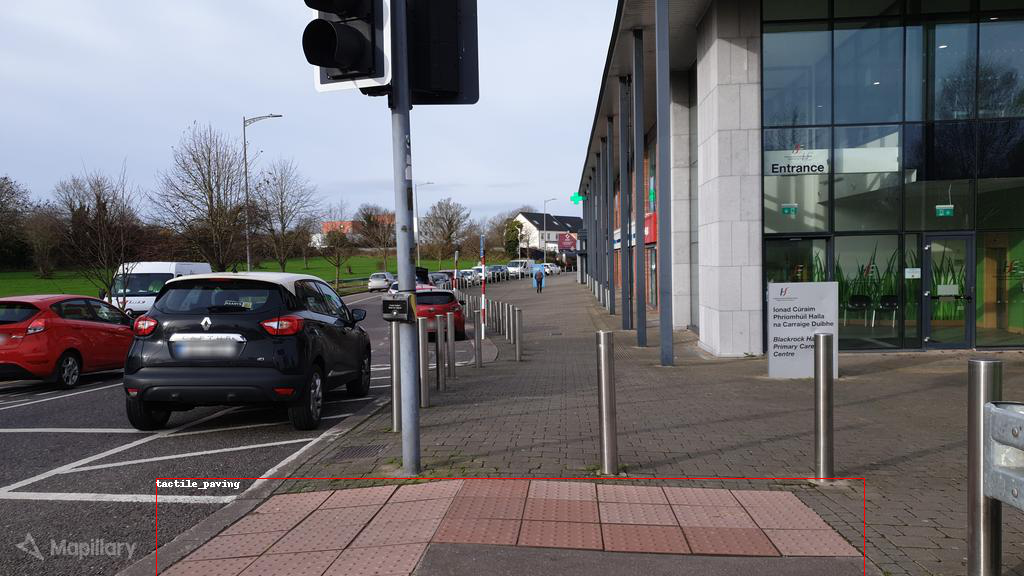

In [7]:
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('crowd4access-images/crowd4access-images/trainval/image', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [8]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad_and_create_pixel_mask(
        pixel_values,
        return_tensors="pt"
    )
    labels = [item[1] for item in batch]

    batch = {}

    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    
    return batch

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=2,
    shuffle=True
)

# test_dataloader = DataLoader(
#     test_dataset,
#     collate_fn=collate_fn,
#     batch_size=2,
#     shuffle=True
# )

In [11]:
batch = next(iter(train_dataloader))
del batch

# Training!

In [12]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
progress_bar = tqdm(range(num_training_steps))

/home/dadofapollo/miniconda3/envs/tactile-paving/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
  0%|          | 0/2703 [00:00<?, ?it/s]

In [13]:
model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

/home/dadofapollo/miniconda3/envs/tactile-paving/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)
  0%|          | 1/2703 [00:11<8:41:59, 11.59s/it]

KeyboardInterrupt: 

Save weights

In [64]:
path_to_weights = ""

model.save_pretrained(path_to_weights)

transformers.models.detr.modeling_detr.DetrForObjectDetection